In [40]:
import os
import json
from glob import glob
from PIL import Image

def load_report_with_images(
    json_dir="../data/DITrans-EMNLP/political_report/jsons/",
    img_dir ="../data/DITrans-EMNLP/political_report/imgs/",
    limit=None        # <── here
):
    json_paths = sorted(glob(os.path.join(json_dir, "*.json")))

    if limit is not None:
        json_paths = json_paths[:limit]

    items = []

    for jp in json_paths:
        base = os.path.splitext(os.path.basename(jp))[0]

        # match image
        img_path = None
        for ext in ["jpg", "jpeg", "png"]:
            candidate = os.path.join(img_dir, f"{base}.{ext}")
            if os.path.exists(candidate):
                img_path = candidate
                break

        if img_path is None:
            print(f"[WARN] No image for {base}")
            continue

        with open(jp, "r", encoding="utf-8") as f:
            data = json.load(f)

        img = Image.open(img_path).convert("RGB")

        items.append((base, data, img))


    return items

# ---- USE IT ----
items = load_report_with_images(limit=10)
print("Loaded:", len(items))

Loaded: 10


In [2]:
!export HF_HUB_OFFLINE=1
!export TRANSFORMERS_OFFLINE=1

In [2]:
from transformers import pipeline


translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="eng_Latn", tgt_lang="mal_Mlym")
translator(["Hello, how are you?", "This is a test sentence."])

Device set to use cuda:0


[{'translation_text': 'ഹലോ, എങ്ങിനെ പോകുന്നു?'},
 {'translation_text': 'ഇത് ഒരു പരീക്ഷണ വാക്യമാണ്.'}]

In [41]:
docs = []
for filename, data, image in items[:10]:
    sentences = {}
    for obj in data.get("objects", []):
        for sen in obj.get("sentences", []):
            info = sen.get("line_info", {})
            sen_id = sen.get("sen_id")
            src = info.get("text_gt")
            tgt = info.get("text_trans_ref")
            if sen_id in sentences.keys():
                if src[0] != ' ':
                    src = ' ' + src
                sentences[sen_id]['src'] += src
            else:
                sentences[sen_id] = {
                    'src': src,
                    'tgt': tgt,
                    'sen_id': sen_id,
                }

    docs.append({
        "sentences": sentences,
    })

docs[1]

{'sentences': {1: {'src': 'For more information on this publication, visit www.rand.org/t/RR2442',
   'tgt': '有关本出版物的更多信息，请访问www.rand.org/t/RR2442',
   'sen_id': 1},
  2: {'src': 'Published by the RAND Corporation, Santa Monica, Calif.',
   'tgt': '兰德公司出版，加州圣莫尼卡',
   'sen_id': 2},
  3: {'src': '©Copyright 2018 RAND Corporation RAND is a registered trademark.',
   'tgt': '©版权所有2018年兰德公司兰德是注册商标。',
   'sen_id': 3},
  4: {'src': 'Limited Print and Electronic Distribution Rights',
   'tgt': '有限的印刷和电子发行权',
   'sen_id': 4},
  5: {'src': 'This document and trademark(s) contained herein are protected by law.',
   'tgt': '本文件和本文件所载商标（或）受法律保护。',
   'sen_id': 5},
  6: {'src': 'This representation of RAND intellectual property is provided for noncommercial use only.',
   'tgt': '兰德公司知识产权的这种表述仅供非商业用途。',
   'sen_id': 6},
  7: {'src': 'Unauthorized posting of this publication online is prohibited.',
   'tgt': '禁止未经授权在网上发布本出版物。',
   'sen_id': 7},
  8: {'src': 'Permission is given to duplicate this docu

In [19]:
# translator = pipeline("translation", model="facebook/nllb-200-3.3B", src_lang="eng_Latn", tgt_lang="zho_Hans")
translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="eng_Latn", tgt_lang="zho_Hans")


for doc in docs:
    sources = [doc['sentences'][sen_id]['src'] for sen_id in doc['sentences'].keys()]
    print(sources)
    targets = sources = [doc['sentences'][sen_id]['tgt'] for sen_id in doc['sentences'].keys()]
    translated = translator(sources)
    for i, sen_id in enumerate(doc['sentences'].keys()):
        doc['sentences'][sen_id]['translated2'] = translated[i]['translation_text']

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
Device set to use cuda:0


['RAND', 'JUSTICE,INFRASTRUCTURE,AND ENVIRONMENT', 'Is Climate Restoration an Appropriate Climate Policy  Goal？', 'Robert J. Lempert,Giacomo Marangoni ,Klaus Keller,Jessica Duke', 'Prepared for the RAND Frederick S. Pardee Center for Long Range Global Policy and the Future Human Condition']
['For more information on this publication, visit www.rand.org/t/RR2442', 'Published by the RAND Corporation, Santa Monica, Calif.', '©Copyright 2018 RAND Corporation RAND is a registered trademark.', 'Limited Print and Electronic Distribution Rights', 'This document and trademark(s) contained herein are protected by law.', 'This representation of RAND intellectual property is provided for noncommercial use only.', 'Unauthorized posting of this publication online is prohibited.', 'Permission is given to duplicate this document for personal use only, as long as it is unaltered and complete.', 'Permission is required from RAND to reproduce, or reuse in another form, any of its research documents for c

In [24]:
import sacrebleu

refs = []
preds = []

for doc in docs:
    pred, ref = [], []
    for sen_id, sen in doc["sentences"].items():
        pred.append(sen["translated2"])
        ref.append(sen["tgt"])
    preds.append(" ".join(pred))
    refs.append(" ".join(ref))

# for doc in docs[:1]:
#     for sen_id, sen in doc["sentences"].items():
#         preds.append(sen["translated2"])
#         refs.append(sen["tgt"])

# sacrebleu expects: 
#   predictions = list[str] 
#   references = list[list[str]]  (list of refs)
bleu = sacrebleu.corpus_bleu(preds, [refs], tokenize='char')

print("BLEU:", bleu.score)

BLEU: 69.95654967601108


In [20]:
docs[0]

{'sentences': {1: {'src': 'RAND',
   'tgt': '兰德公司',
   'sen_id': 1,
   'translated': '兰德公司',
   'translated2': '兰德公司'},
  2: {'src': 'JUSTICE,INFRASTRUCTURE,AND ENVIRONMENT',
   'tgt': '正义、基础设施与环境',
   'sen_id': 2,
   'translated': '正义,基础设施与环境',
   'translated2': '正义,基础设施与环境'},
  3: {'src': 'Is Climate Restoration an Appropriate Climate Policy  Goal？',
   'tgt': '恢复气候是一个适当的气候政策目标吗？',
   'sen_id': 3,
   'translated': '恢复气候是一个适当的气候政策目标吗?',
   'translated2': '恢复气候是适当的气候政策目标吗?'},
  4: {'src': 'Robert J. Lempert,Giacomo Marangoni ,Klaus Keller,Jessica Duke',
   'tgt': '罗伯特·J·兰佩尔，贾科莫·马兰戈尼，克劳斯·凯勒，杰西卡·杜克',
   'sen_id': 4,
   'translated': '罗伯特·J·兰佩尔,贾科莫·马兰戈尼,克劳斯·凯勒,杰西卡·杜克',
   'translated2': '罗伯特·J·兰佩尔,贾科莫·马兰戈尼,克劳斯·凯勒,杰西卡·杜克'},
  5: {'src': 'Prepared for the RAND Frederick S. Pardee Center for Long Range Global Policy and the Future Human Condition',
   'tgt': '为兰德弗雷德里克-S-帕迪长期全球政策和未来人类状况中心准备',
   'sen_id': 5,
   'translated': '为兰德弗雷德里克-S-帕迪长期全球政策和未来人类状况中心准备',
   'translated2': '为兰德弗雷德里克-S-帕迪长期

In [56]:
docs = []
for filename, data, image in items:
    sentences = {}
    for obj in data.get("objects", []):
        for sen in obj.get("sentences", []):
            info = sen.get("line_info", {})
            sen_id = sen.get("sen_id")
            src = info.get("text_gt")
            tgt = info.get("text_trans_ref")
            box = info.get("line_box")
            x_min, y_min, x_max, y_max = box[0]['x'], box[0]['y'], box[2]['x'], box[2]['y']
            if sen_id in sentences.keys():
                if src[0] != ' ':
                    src = ' ' + src
                sentences[sen_id]['src'] += src
            else:
                sentences[sen_id] = {
                    'src': src,
                    'tgt': tgt,
                    'sen_id': sen_id,
                    'box': {
                        'x_min': x_min,
                        'y_min': y_min,
                        'x_max': x_max,
                        'y_max': y_max,
                    }
                }

    docs.append({
        "sentences": sentences,
    })

docs[0]

{'sentences': {1: {'src': 'RAND',
   'tgt': '兰德公司',
   'sen_id': 1,
   'box': {'x_min': 153.5910357159947,
    'y_min': 209.98255473432644,
    'x_max': 219.79957046217172,
    'y_max': 229.03004669976124}},
  2: {'src': 'JUSTICE,INFRASTRUCTURE,AND ENVIRONMENT',
   'tgt': '正义、基础设施与环境',
   'sen_id': 2,
   'box': {'x_min': 235.66715604486117,
    'y_min': 201.235980661022,
    'x_max': 737.1002429242261,
    'y_max': 238.43178669820014}},
  3: {'src': 'Is Climate Restoration an Appropriate Climate Policy  Goal？',
   'tgt': '恢复气候是一个适当的气候政策目标吗？',
   'sen_id': 3,
   'box': {'x_min': 139.6185679040431,
    'y_min': 519.1765391181959,
    'x_max': 806.4242446064242,
    'y_max': 599.7923115120252}},
  4: {'src': 'Robert J. Lempert,Giacomo Marangoni ,Klaus Keller,Jessica Duke',
   'tgt': '罗伯特·J·兰佩尔，贾科莫·马兰戈尼，克劳斯·凯勒，杰西卡·杜克',
   'sen_id': 4,
   'box': {'x_min': 139.6185679040431,
    'y_min': 996.8280334493815,
    'x_max': 864.8060703814527,
    'y_max': 1048.5897752491653}},
  5: {'src': 'Prepa

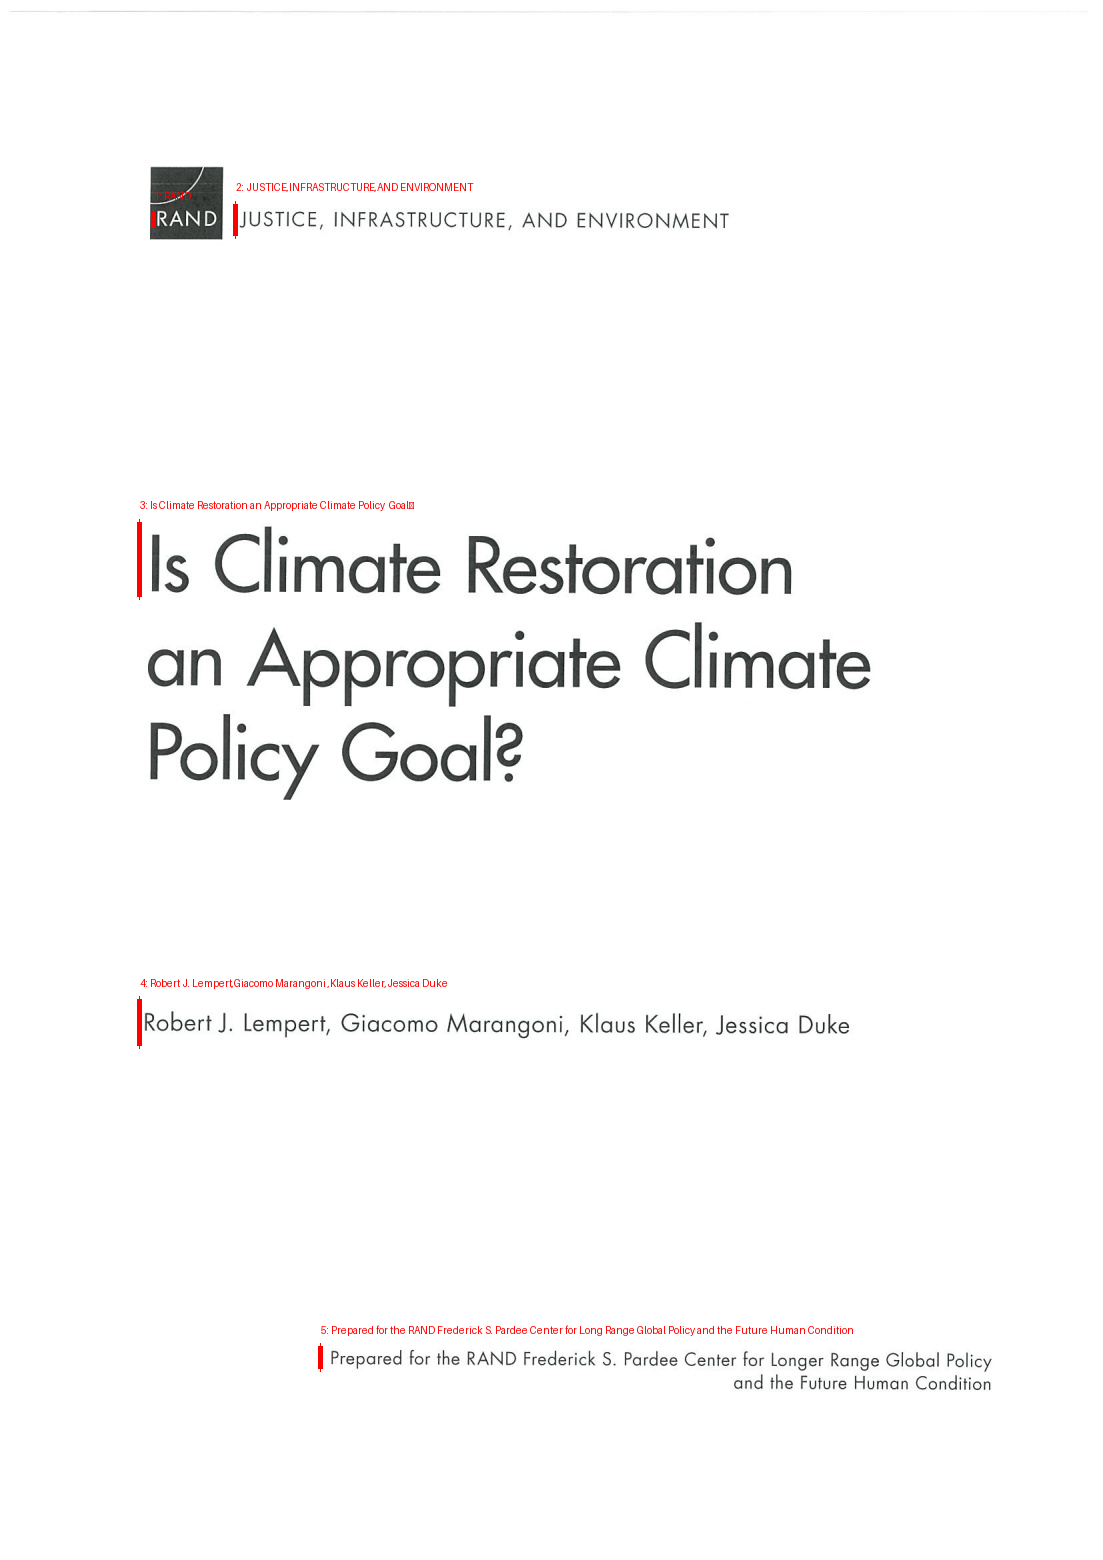

In [57]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def visualize_doc(image, doc, show_text=True, color="red", width=3):
    """
    Draw sentence boxes from `doc` onto `image`.

    image: PIL.Image
    doc:   {"sentences": {sen_id: {...}}}
    """
    img = image.copy()
    draw = ImageDraw.Draw(img)

    # Optional font (PIL default works, but you can load a TTF)
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    for sen_id, sen_data in doc["sentences"].items():
        box = sen_data["box"]

        x_min = box["x_min"]
        y_min = box["y_min"]
        x_max = box["x_max"]
        y_max = box["y_max"]

        # Draw rectangle
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=width)

        # Draw ID or text
        if show_text:
            text = f"{sen_id}: {sen_data['src']}"
            draw.text((x_min, y_min - 20), text, fill=color, font=font)

    return img

img = visualize_doc(items[0][2], docs[0])
display(vis_img)